# LaLiga Data Analysis

Write a Jupyter Notebook called LaLigaDataAnalysis.ipynb in folder analysis/ with your answers to the following exercises/questions. Once you are done with it, export it to HTML and save the result in reports/ folder from the repo. Make sure that your notebook can be rerun from scratch without any errors.

In [69]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

In [70]:
con = sqlite3.connect("laliga.sqlite")
query = "SELECT * from 'MATCHES'"
df = pd.read_sql_query(query, con)
con.close()
df

,season,division,matchday,date,time,home_team,away_team,score
0,1928-1929,1,1,2/10/29,None,Arenas Club,Athletic Madrid,2:3
1,1928-1929,1,1,2/10/29,None,Espanyol,Real Unión,3:2
2,1928-1929,1,1,2/10/29,None,Real Madrid,Catalunya,5:0
3,1928-1929,1,1,2/10/29,None,Donostia,Athletic,1:1
4,1928-1929,1,1,2/12/29,None,Racing,Barcelona,0:2
...,...,...,...,...,...,...,...,...
48775,2021-2022,2,42,5/29/22,None,Real Oviedo,UD Ibiza,None
48776,2021-2022,2,42,5/29/22,None,Real Sociedad B,Real Zaragoza,None
48777,2021-2022,2,42,5/29/22,None,Sporting Gijón,UD Las Palmas,None
48778,2021-2022,2,42,5/29/22,None,CD Tenerife,FC Cartagena,None


1. Is it true that the home team is more likely to win? Make a pie chart showing the result distribution (whether home team wins, visitor team wins, or there's a tie) of all matches in the data. Write in the plot the percentage of each category.

In [71]:
df["result"] = None
df["goals_home"] = df["score"].str.split(":").str[0]
df["goals_visitor"] = df["score"].str.split(":").str[1]
df.loc[df["goals_home"] > df["goals_visitor"], "result"] = 'home'
df.loc[df["goals_home"] == df["goals_visitor"], "result"] = 'tie'
df.loc[df["goals_home"] < df["goals_visitor"], "result"] = 'visitor'
genre_counts = df["result"].value_counts()
genre_counts

result
home       25317
tie        12280
visitor    10403
Name: count, dtype: int64

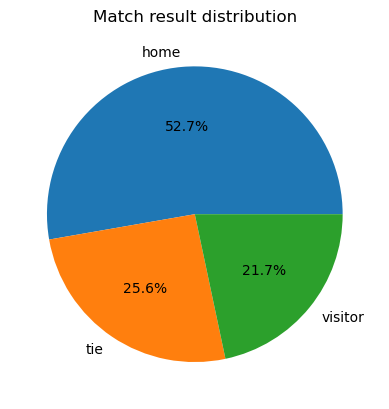

In [72]:
plt.pie(genre_counts, labels=genre_counts.index, autopct='%1.1f%%')
plt.title("Match result distribution")
plt.show()

2. What are the top ten scoring teams of all time? What are the ten teams that concede the most? Make two bar plot charts showing each of them. Consider only matches played in 1st division.
What have been the biggest wins? Of course, when we say biggest we mean
those with the highest goal difference. Show the top ten of them in a table.

In [73]:
df1 = df.loc[df["division"] == 1].dropna(subset=["score"])
df1

,season,division,matchday,date,time,home_team,away_team,score,result,goals_home,goals_visitor
0,1928-1929,1,1,2/10/29,None,Arenas Club,Athletic Madrid,2:3,visitor,2,3
1,1928-1929,1,1,2/10/29,None,Espanyol,Real Unión,3:2,home,3,2
2,1928-1929,1,1,2/10/29,None,Real Madrid,Catalunya,5:0,home,5,0
3,1928-1929,1,1,2/10/29,None,Donostia,Athletic,1:1,tie,1,1
4,1928-1929,1,1,2/12/29,None,Racing,Barcelona,0:2,visitor,0,2
...,...,...,...,...,...,...,...,...,...,...,...
47963,2021-2022,1,3,8/28/21,10:00 PM,Real Betis,Real Madrid,0:1,visitor,0,1
47964,2021-2022,1,3,8/29/21,5:00 PM,Barcelona,Getafe,2:1,home,2,1
47965,2021-2022,1,3,8/29/21,7:30 PM,Cádiz CF,CA Osasuna,2:3,visitor,2,3
47966,2021-2022,1,3,8/29/21,7:30 PM,Rayo Vallecano,Granada CF,4:0,home,4,0


In [74]:
df1["goals_home"] = df1["goals_home"].astype(int)
df1["goals_visitor"] = df1["goals_visitor"].astype(int)
df1

,season,division,matchday,date,time,home_team,away_team,score,result,goals_home,goals_visitor
0,1928-1929,1,1,2/10/29,None,Arenas Club,Athletic Madrid,2:3,visitor,2,3
1,1928-1929,1,1,2/10/29,None,Espanyol,Real Unión,3:2,home,3,2
2,1928-1929,1,1,2/10/29,None,Real Madrid,Catalunya,5:0,home,5,0
3,1928-1929,1,1,2/10/29,None,Donostia,Athletic,1:1,tie,1,1
4,1928-1929,1,1,2/12/29,None,Racing,Barcelona,0:2,visitor,0,2
...,...,...,...,...,...,...,...,...,...,...,...
47963,2021-2022,1,3,8/28/21,10:00 PM,Real Betis,Real Madrid,0:1,visitor,0,1
47964,2021-2022,1,3,8/29/21,5:00 PM,Barcelona,Getafe,2:1,home,2,1
47965,2021-2022,1,3,8/29/21,7:30 PM,Cádiz CF,CA Osasuna,2:3,visitor,2,3
47966,2021-2022,1,3,8/29/21,7:30 PM,Rayo Vallecano,Granada CF,4:0,home,4,0


In [75]:
df2 = df1.groupby("home_team")
df3 = df1.groupby("away_team")

<BarContainer object of 10 artists>

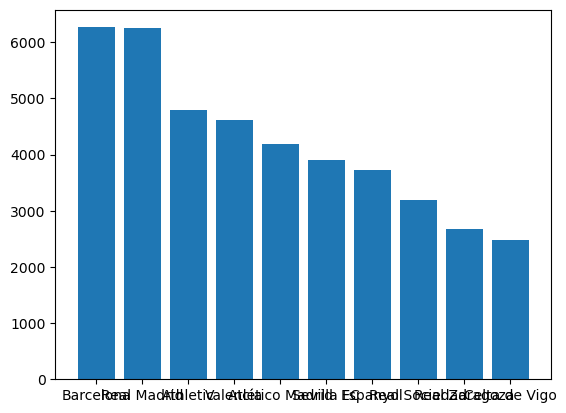

In [76]:
goals = df2["goals_home"].sum() + df3["goals_visitor"].sum()
total_goals = goals.sort_values(ascending = False).head(10)
plt.bar(total_goals.index, total_goals)

In [77]:
total_goals

home_team
Barcelona          6267
Real Madrid        6249
Athletic           4802
Valencia           4615
Atlético Madrid    4184
Sevilla FC         3903
Espanyol           3720
Real Sociedad      3200
Real Zaragoza      2683
Celta de Vigo      2483
dtype: int64

<BarContainer object of 10 artists>

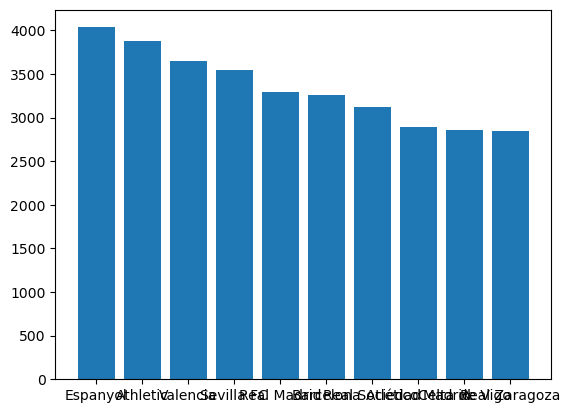

In [78]:
goals = df3["goals_home"].sum() + df2["goals_visitor"].sum()
conceded_goals = goals.sort_values(ascending = False).head(10)
plt.bar(conceded_goals.index, conceded_goals)

In [79]:
conceded_goals

away_team
Espanyol           4034
Athletic           3875
Valencia           3649
Sevilla FC         3546
Real Madrid        3287
Barcelona          3259
Real Sociedad      3126
Atlético Madrid    2894
Celta de Vigo      2856
Real Zaragoza      2847
dtype: int64

In [80]:
df1["difference"] = abs(df1["goals_home"] - df1["goals_visitor"])
df1.sort_values("difference", ascending=False).head(10)

,season,division,matchday,date,time,home_team,away_team,score,result,goals_home,goals_visitor,difference
225,1930-1931,1,10,2/8/31,None,Athletic,Barcelona,12:1,home,12,1,11
936,1940-1941,1,1,9/29/40,None,Sevilla FC,Barcelona,11:1,home,11,1,10
1071,1941-1942,1,1,9/28/41,None,Sevilla FC,Real Oviedo,10:0,home,10,0,10
2787,1950-1951,1,11,11/19/50,None,Athletic,Lérida,10:0,home,10,0,10
1168,1941-1942,1,15,1/11/42,None,Athletic,Celta de Vigo,10:0,home,10,0,10
10024,1978-1979,1,16,1/14/79,None,Barcelona,Rayo Vallecano,9:0,home,9,0,9
2574,1949-1950,1,8,10/23/49,None,Celta de Vigo,Gimnàstic,10:1,home,10,1,9
5027,1959-1960,1,21,2/7/60,None,Real Madrid,Elche CF,11:2,visitor,11,2,9
6,1928-1929,1,2,2/17/29,None,Athletic,Espanyol,9:0,home,9,0,9
2715,1950-1951,1,2,9/17/50,None,CD Málaga,Lérida,9:0,home,9,0,9


In [81]:
df

,season,division,matchday,date,time,home_team,away_team,score,result,goals_home,goals_visitor
0,1928-1929,1,1,2/10/29,None,Arenas Club,Athletic Madrid,2:3,visitor,2,3
1,1928-1929,1,1,2/10/29,None,Espanyol,Real Unión,3:2,home,3,2
2,1928-1929,1,1,2/10/29,None,Real Madrid,Catalunya,5:0,home,5,0
3,1928-1929,1,1,2/10/29,None,Donostia,Athletic,1:1,tie,1,1
4,1928-1929,1,1,2/12/29,None,Racing,Barcelona,0:2,visitor,0,2
...,...,...,...,...,...,...,...,...,...,...,...
48775,2021-2022,2,42,5/29/22,None,Real Oviedo,UD Ibiza,None,None,None,None
48776,2021-2022,2,42,5/29/22,None,Real Sociedad B,Real Zaragoza,None,None,None,None
48777,2021-2022,2,42,5/29/22,None,Sporting Gijón,UD Las Palmas,None,None,None,None
48778,2021-2022,2,42,5/29/22,None,CD Tenerife,FC Cartagena,None,None,None,None


3. There has been a lot of discussion about how LaLiga’s television rights have changed game schedules in the last years. Make a bar plot chart showing the number of matches played each weekday, and make also a histogram
of match time. Compare this two graphics between seasons 2000-2001 and 2020-2021.

In [82]:
df["date"] = pd.to_datetime(df["date"], format = "%m/%d/%y")
df["time"] = pd.to_datetime(df["time"], format = "%I:%M %p", errors = "coerce").dt.strftime("%H:%M")

In [83]:
weekday_counts = df["date"].dt.day_name().value_counts()
hour_counts = df["time"].dropna().value_counts()

<BarContainer object of 7 artists>

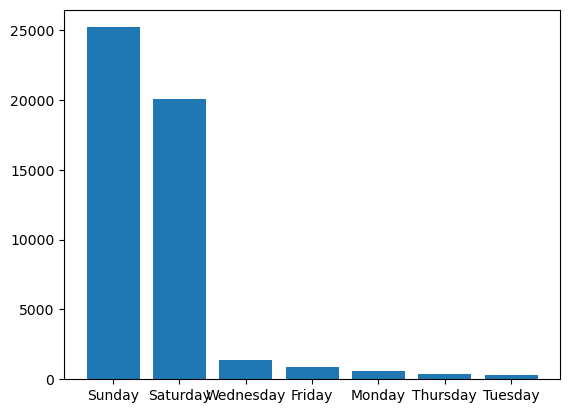

In [84]:
plt.bar(weekday_counts.index, weekday_counts)

<BarContainer object of 43 artists>

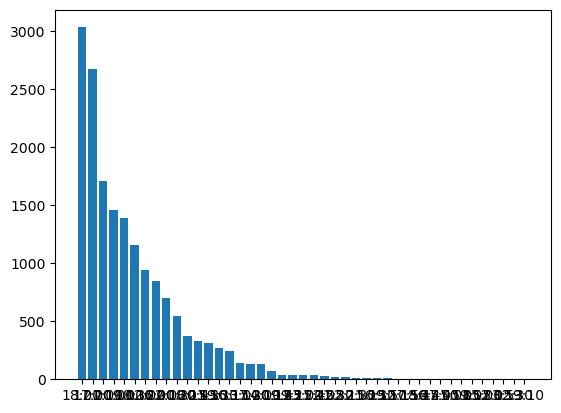

In [85]:
plt.bar(hour_counts.index, hour_counts)

<BarContainer object of 6 artists>

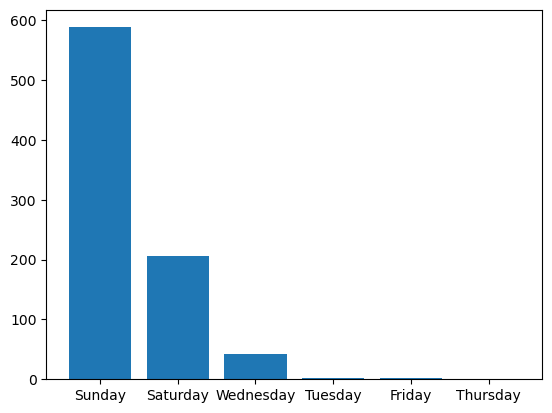

In [86]:
weekday_counts = df.loc[df["season"] == "2000-2001", "date"].dt.day_name().value_counts()
plt.bar(weekday_counts.index, weekday_counts)

<BarContainer object of 7 artists>

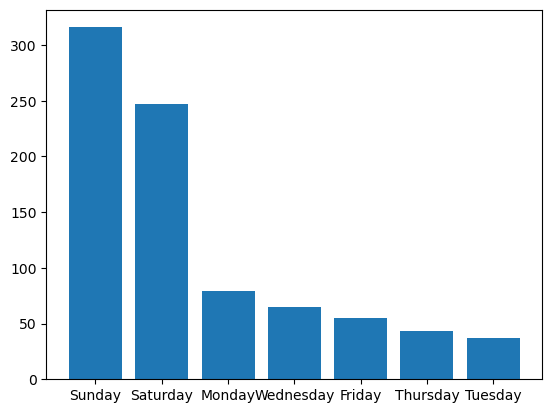

In [87]:
weekday_counts = df.loc[df["season"] == "2020-2021", "date"].dt.day_name().value_counts()
plt.bar(weekday_counts.index, weekday_counts)

hour_counts = df.loc[df["season"] == "2020-2021", "time"].dropna().value_counts()
plt.bar(hour_counts.index, hour_counts)

<BarContainer object of 13 artists>

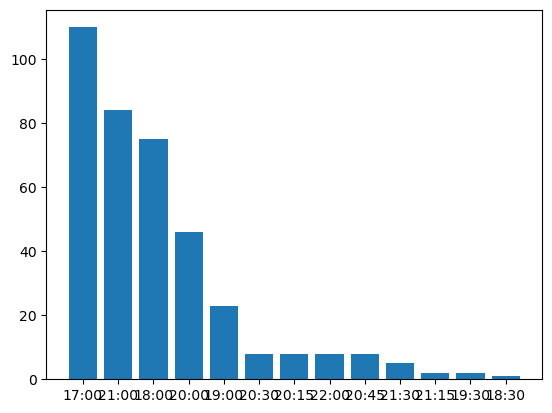

In [88]:
hour_counts = df.loc[df["season"] == "2000-2001", "time"].dropna().value_counts()
plt.bar(hour_counts.index, hour_counts)

4. Build a cross results table for season 2020-2021 (1st division). Figure 1 is an example taken from Wikipedia. Try to make it the most similar to this one, painting the background of each cell according to result (green in case local team wins and red in case visitor team wins). Also, could you model the intensity of this background color with the goal difference from the match?

In [89]:
crosstab = pd.crosstab(index = df1.loc[df1["season"] == "2020-2021"]["home_team"], columns = df1.loc[df1["season"] == "2020-2021"]["away_team"], values = df1.loc[df1["season"] == "2020-2021"]["score"], 
                       aggfunc = lambda x: " ".join(x)).fillna("--")
crosstab

away_team,Alavés,Athletic,Atlético Madrid,Barcelona,CA Osasuna,Celta de Vigo,Cádiz CF,Elche CF,Getafe,Granada CF,Levante,Real Betis,Real Madrid,Real Sociedad,Real Valladolid,SD Eibar,SD Huesca,Sevilla FC,Valencia,Villarreal
home_team,,,,,,,,,,,,,,,,,,,,
Alavés,--,1:0,1:2,1:1,0:1,1:3,1:1,0:2,0:0,4:2,2:2,0:1,1:4,0:0,1:0,2:1,1:0,1:2,2:2,2:1
Athletic,0:0,--,2:1,2:3,2:2,0:2,0:1,1:0,5:1,2:1,2:0,4:0,0:1,0:1,2:2,1:1,2:0,2:1,1:1,1:1
Atlético Madrid,1:0,2:1,--,1:0,2:1,2:2,4:0,3:1,1:0,6:1,0:2,2:0,1:1,2:1,2:0,5:0,2:0,2:0,3:1,0:0
Barcelona,5:1,2:1,0:0,--,4:0,1:2,1:1,3:0,5:2,1:2,1:0,5:2,1:3,2:1,1:0,1:1,4:1,1:1,2:2,4:0
CA Osasuna,1:1,1:0,1:3,0:2,--,2:0,3:2,2:0,0:0,3:1,1:3,0:2,0:0,0:1,0:0,2:1,1:1,0:2,3:1,1:3
Celta de Vigo,2:0,0:0,0:2,0:3,2:1,--,4:0,3:1,1:0,3:1,2:0,2:3,1:3,1:4,1:1,1:1,2:1,3:4,2:1,0:4
Cádiz CF,3:1,0:4,2:4,2:1,0:2,0:0,--,1:3,0:2,1:1,2:2,0:1,0:3,0:1,0:0,1:0,2:1,1:3,2:1,0:0
Elche CF,0:2,2:0,0:1,0:2,2:2,1:1,1:1,--,1:3,0:1,1:0,1:1,1:1,0:3,1:1,1:0,0:0,2:1,2:1,2:2
Getafe,0:0,1:1,0:0,1:0,1:0,1:1,0:1,1:1,--,0:1,2:1,3:0,0:0,0:1,0:1,0:1,1:0,0:1,3:0,1:3


In [90]:
#FUNCIÓN:

def color_cells(result):
    if result == "—":
        return 'background-color: rgba(192, 192, 192, 0.5)'
    else:
        a = result.split("-")[0]
        b = result.split("-")[1]
    if a < b:
        return 'background-color: rgba(255, 0, 0, 0.5)'
    elif a > b:
        return 'background-color: rgba(0, 255, 0, 0.5)'
    elif a == b:
        return 'background-color: rgba(255, 255, 0, 0.5)'
    else:
        return ''

def plot_cross_results_table(season, division):
    dff = df.loc[(df["division"] == division) & (df["season"] == season)]
    crosstab = pd.crosstab(index = dff["home_team"], columns = dff["away_team"], values = dff["goals_home"].astype(str) + "-" + dff["goals_visitor"].astype(str), 
                       aggfunc = lambda x: " ".join(x)).fillna("—")
    styled_crosstab = crosstab.style.map(color_cells)
    return styled_crosstab
    
plot_cross_results_table("2020-2021", 1)

away_team,Alavés,Athletic,Atlético Madrid,Barcelona,CA Osasuna,Celta de Vigo,Cádiz CF,Elche CF,Getafe,Granada CF,Levante,Real Betis,Real Madrid,Real Sociedad,Real Valladolid,SD Eibar,SD Huesca,Sevilla FC,Valencia,Villarreal
home_team,,,,,,,,,,,,,,,,,,,,
Alavés,—,1-0,1-2,1-1,0-1,1-3,1-1,0-2,0-0,4-2,2-2,0-1,1-4,0-0,1-0,2-1,1-0,1-2,2-2,2-1
Athletic,0-0,—,2-1,2-3,2-2,0-2,0-1,1-0,5-1,2-1,2-0,4-0,0-1,0-1,2-2,1-1,2-0,2-1,1-1,1-1
Atlético Madrid,1-0,2-1,—,1-0,2-1,2-2,4-0,3-1,1-0,6-1,0-2,2-0,1-1,2-1,2-0,5-0,2-0,2-0,3-1,0-0
Barcelona,5-1,2-1,0-0,—,4-0,1-2,1-1,3-0,5-2,1-2,1-0,5-2,1-3,2-1,1-0,1-1,4-1,1-1,2-2,4-0
CA Osasuna,1-1,1-0,1-3,0-2,—,2-0,3-2,2-0,0-0,3-1,1-3,0-2,0-0,0-1,0-0,2-1,1-1,0-2,3-1,1-3
Celta de Vigo,2-0,0-0,0-2,0-3,2-1,—,4-0,3-1,1-0,3-1,2-0,2-3,1-3,1-4,1-1,1-1,2-1,3-4,2-1,0-4
Cádiz CF,3-1,0-4,2-4,2-1,0-2,0-0,—,1-3,0-2,1-1,2-2,0-1,0-3,0-1,0-0,1-0,2-1,1-3,2-1,0-0
Elche CF,0-2,2-0,0-1,0-2,2-2,1-1,1-1,—,1-3,0-1,1-0,1-1,1-1,0-3,1-1,1-0,0-0,2-1,2-1,2-2
Getafe,0-0,1-1,0-0,1-0,1-0,1-1,0-1,1-1,—,0-1,2-1,3-0,0-0,0-1,0-1,0-1,1-0,0-1,3-0,1-3


7. Create a table with the final standings of each season (and division), that is, a table that contains all the teams ordered (in descending order) by the number of points they got during that season, and some other aggregate statistics. The table must contain the following columns: season, division, ranking, team, GF (total goals scored), GA (total goals conceded), GD (goals difference), W (total wins), L (total loses), T (total ties), Pts (points). Remember that, in football, you earn 3 points per victory, and 1 point per tie (none for loses). In case two teams have same number of points, order by GD (descending), and then by GF (also descending). Order the table so that standings of one season come before standings of previous one, and standings of 1st division come before standings of 2nd division.

In [91]:
df.loc[df["season"] != "2021-2022"]

,season,division,matchday,date,time,home_team,away_team,score,result,goals_home,goals_visitor
0,1928-1929,1,1,2029-02-10,NaN,Arenas Club,Athletic Madrid,2:3,visitor,2,3
1,1928-1929,1,1,2029-02-10,NaN,Espanyol,Real Unión,3:2,home,3,2
2,1928-1929,1,1,2029-02-10,NaN,Real Madrid,Catalunya,5:0,home,5,0
3,1928-1929,1,1,2029-02-10,NaN,Donostia,Athletic,1:1,tie,1,1
4,1928-1929,1,1,2029-02-12,NaN,Racing,Barcelona,0:2,visitor,0,2
...,...,...,...,...,...,...,...,...,...,...,...
47933,2020-2021,2,42,2021-05-30,21:00,CD Mirandés,CE Sabadell,0:2,visitor,0,2
47934,2020-2021,2,42,2021-05-30,21:00,Ponferradina,RCD Mallorca,2:2,tie,2,2
47935,2020-2021,2,42,2021-05-30,21:00,Rayo Vallecano,CD Lugo,0:1,visitor,0,1
47936,2020-2021,2,42,2021-05-30,21:00,Real Zaragoza,CD Leganés,0:5,visitor,0,5


In [92]:
df_ranking = df.loc[df["season"] != "2021-2022"]

df_ranking = df_ranking.copy()
df_ranking["goals_home"] = df_ranking["goals_home"].astype(int)
df_ranking["goals_visitor"] = df_ranking["goals_visitor"].astype(int)

points_home = df_ranking[df_ranking["result"] == "home"].groupby(["season", "division", "home_team"])["result"].count() * 3
points_home.index = points_home.index.set_names("team", level="home_team")
points_tie1 = df_ranking[df_ranking["result"] == "tie"].groupby(["season", "division", "home_team"])["result"].count()
points_tie1.index = points_tie1.index.set_names("team", level="home_team")
points_tie2 = df_ranking[df_ranking["result"] == "tie"].groupby(["season", "division", "away_team"])["result"].count()
points_tie2.index = points_tie2.index.set_names("team", level="away_team")
points_visitor = df_ranking[df_ranking["result"] == "visitor"].groupby(["season", "division", "away_team"])["result"].count() * 3
points_visitor.index = points_visitor.index.set_names("team", level="away_team")
points = points_home.add(points_tie1, fill_value=0).add(points_tie2, fill_value=0).add(points_visitor, fill_value=0).astype(int)

loss_home = df_ranking[df_ranking["result"] == "visitor"].groupby(["season", "division", "home_team"])["result"].count()
loss_home.index = loss_home.index.set_names("team", level="home_team")
loss_visitor = df_ranking[df_ranking["result"] == "home"].groupby(["season", "division", "away_team"])["result"].count()
loss_visitor.index = loss_visitor.index.set_names("team", level="away_team")
loss = loss_home.add(loss_visitor, fill_value=0)

win_home = df_ranking[df_ranking["result"] == "home"].groupby(["season", "division", "home_team"])["result"].count()
win_home.index = win_home.index.set_names("team", level="home_team")
win_visitor = df_ranking[df_ranking["result"] == "visitor"].groupby(["season", "division", "away_team"])["result"].count()
win_visitor.index = win_visitor.index.set_names("team", level="away_team")
win = win_home.add(win_visitor, fill_value=0).astype(int)

tie_home = df_ranking[df_ranking["result"] == "tie"].groupby(["season", "division", "home_team"])["result"].count()
tie_home.index = tie_home.index.set_names("team", level="home_team")
tie_visitor = df_ranking[df_ranking["result"] == "tie"].groupby(["season", "division", "away_team"])["result"].count()
tie_visitor.index = tie_visitor.index.set_names("team", level="away_team")
tie = tie_home.add(tie_visitor, fill_value=0)

goals_home = df_ranking.groupby(["season", "division", "home_team"])["goals_home"].sum()
goals_visitor = df_ranking.groupby(["season", "division", "away_team"])["goals_visitor"].sum()
GF = goals_home.add(goals_visitor, fill_value=0)
GF.index = GF.index.set_names("team", level="home_team")

goals_home = df_ranking.groupby(["season", "division", "home_team"])["goals_visitor"].sum()
goals_visitor = df_ranking.groupby(["season", "division", "away_team"])["goals_home"].sum()
GA = goals_home.add(goals_visitor, fill_value=0)
GA.index = GA.index.set_names("team", level="home_team")

GD = GF - GA

df_result = pd.DataFrame({
    "GF": GF,
    "GA": GA,
    "GD": GD,
    "W": win,
    "L": loss,
    "T": tie,
    "Pts": points
}).reset_index()

def add_ranking(df):
    df.insert(2, "rank", df["Pts"].rank(ascending=False))
    return df

df_result = df_result.groupby(['season', 'division']).apply(add_ranking)
df_result = df_result.reset_index(drop=True).sort_values(["season", "division", "Pts"], ascending=[False, True, False]).reset_index(drop=True)

df_result

,season,division,rank,team,GF,GA,GD,W,L,T,Pts
0,2020-2021,1,1.0,Atlético Madrid,67,25,42,26.0,4.0,8.0,86.0
1,2020-2021,1,2.0,Real Madrid,67,28,39,25.0,4.0,9.0,84.0
2,2020-2021,1,3.0,Barcelona,85,38,47,24.0,7.0,7.0,79.0
3,2020-2021,1,4.0,Sevilla FC,53,33,20,24.0,9.0,5.0,77.0
4,2020-2021,1,5.0,Real Sociedad,59,38,21,17.0,10.0,11.0,62.0
...,...,...,...,...,...,...,...,...,...,...,...
2739,1928-1929,1,6.0,Athletic Madrid,43,41,2,8.0,8.0,2.0,26.0
2740,1928-1929,1,7.0,Espanyol,32,38,-6,7.0,7.0,4.0,25.0
2741,1928-1929,1,8.0,Catalunya,45,49,-4,6.0,8.0,4.0,22.0
2742,1928-1929,1,9.0,Real Unión,40,42,-2,5.0,11.0,2.0,17.0


8. Villarreal is a team that has grown a lot in recent decades. Specially ever since some billionaire guy bought it (Fernando Roig, from Mercadona). Make a line plot showing the rank of Villarreal at the end of each season, from the oldest ones (left) to the earliest ones (right). Consider rankings in 2nd division to be a continuation of the 1st one, that is, if there’s N teams in
1st division and Villarreal got r position in 2nd division, then it should be placed in N + r. Draw in the same plot a line showing the cut between 1st and 2nd division. Write a function that, given n team names, plots the graph described above of each one of them superposed. Function prototype should be like plot_- ranking_evolution(team1, team2, ..., teamN) and return the plot object (note that function should not take one array-type argument, but n arguments). Use it to compare the evolution of all the teams that currentlyplay in 1st division.

In [93]:
df_result.loc[df_result["team"] == "Villarreal"].sort_values("season")

,season,division,rank,team,GF,GA,GD,W,L,T,Pts
1894,1970-1971,2,16.0,Villarreal,37,55,-18,11.0,17.0,10.0,43.0
1854,1971-1972,2,17.0,Villarreal,30,48,-18,10.0,16.0,12.0,42.0
1203,1992-1993,2,12.0,Villarreal,38,51,-13,13.0,17.0,8.0,47.0
1161,1993-1994,2,10.0,Villarreal,29,48,-19,14.0,18.0,6.0,48.0
1123,1994-1995,2,12.0,Villarreal,41,36,5,11.0,11.0,16.0,49.0
1087,1995-1996,2,15.0,Villarreal,32,39,-7,11.0,16.0,11.0,44.0
1040,1996-1997,2,10.5,Villarreal,38,52,-14,13.0,16.0,9.0,48.0
989,1997-1998,2,3.5,Villarreal,51,38,13,19.0,7.0,16.0,73.0
941,1998-1999,1,18.0,Villarreal,47,63,-16,8.0,18.0,12.0,36.0
905,1999-2000,2,3.5,Villarreal,61,46,15,18.0,12.0,12.0,66.0


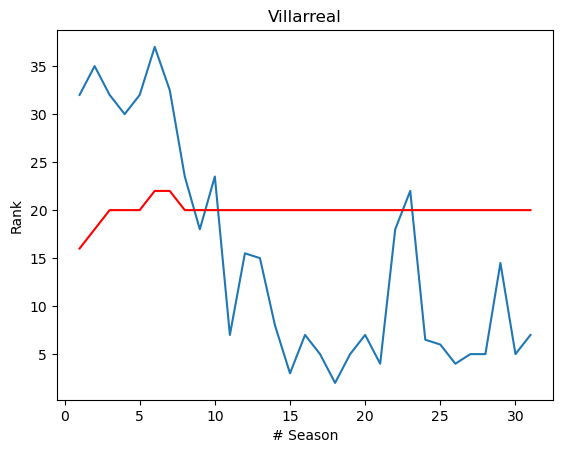

1894    1970-1971
1854    1971-1972
1203    1992-1993
1161    1993-1994
1123    1994-1995
1087    1995-1996
1040    1996-1997
989     1997-1998
941     1998-1999
905     1999-2000
846     2000-2001
813     2001-2002
770     2002-2003
721     2003-2004
674     2004-2005
636     2005-2006
592     2006-2007
547     2007-2008
508     2008-2009
468     2009-2010
423     2010-2011
395     2011-2012
357     2012-2013
300     2013-2014
257     2014-2015
213     2015-2016
172     2016-2017
130     2017-2018
98      2018-2019
46      2019-2020
6       2020-2021
Name: season, dtype: object

In [148]:
df_new = df_result.loc[df_result["team"] == "Villarreal"].sort_values("season")

df_new.loc[df_new["division"] == 2]["season"].values
teams_count = df_result.loc[df_result["division"] == 1]["season"].value_counts()[df_new.loc[df_new["division"] == 2]["season"].values]
#Esto es el número de equipos de primera división de cada temporada
teams_count

#Estas son las temporadas de segunda división que hay que modificar
for season in df_new.loc[df_new["division"] == 2]["season"].values:
    df_new.loc[df_new["season"] == season, "rank"] = df_new.loc[df_new["season"] == season, "rank"] + teams_count[season]

teams1 = df_result.loc[df_result["division"] == 1]["season"].value_counts()[df_new.loc[df_new["team"] == "Villarreal"]["season"].values].values

plt.plot(np.arange(1, len(df_new["season"])+1), df_new["rank"].values)
plt.plot(np.arange(1, len(df_new["season"])+1), teams1, color="red")
plt.xlabel("# Season")
plt.ylabel("Rank")
plt.title("Villarreal")
plt.show()

In [183]:
# FUNCTION

def ranking_evolution(*teams):
    
    for team in teams:
        
        df_new = df_result.loc[df_result["team"] == team].sort_values("season")
        df_new.loc[df_new["division"] == 2]["season"].values
        teams_count = df_result.loc[df_result["division"] == 1]["season"].value_counts()[df_new.loc[df_new["division"] == 2]["season"].values]
        #Esto es el número de equipos de primera división de cada temporada
        teams_count

        #Estas son las temporadas de segunda división que hay que modificar
        for season in df_new.loc[df_new["division"] == 2]["season"].values:
            df_new.loc[df_new["season"] == season, "rank"] = df_new.loc[df_new["season"] == season, "rank"] + teams_count[season]

        teams1 = df_result.loc[df_result["division"] == 1]["season"].value_counts()[df_new.loc[df_new["team"] == team]["season"].values].values
        
        plt.plot(df_new["season"].values, df_new["rank"].values)
        plt.xlabel("# Season")
        plt.ylabel("Rank")
        plt.legend(team)
    plt.title("Team evolution")
    plt.plot(df_new["season"].values, teams1, color="red")
    plt.show()

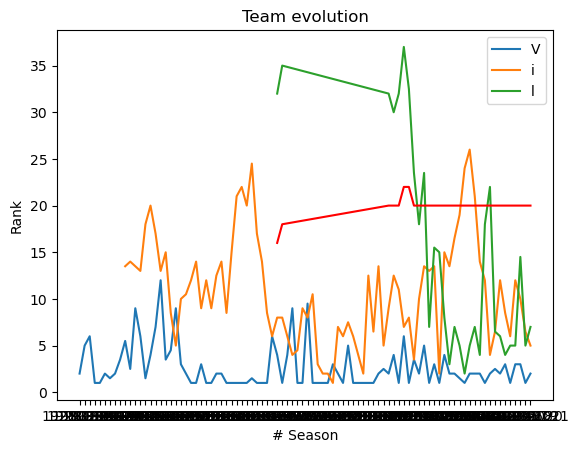

In [186]:
ranking_evolution("Real Madrid", "Real Sociedad", "Villarreal")